## Softmax Regression Model
이번 실습의 목표는 다음과 같습니다.

- 1. 각각의 example들이 별도의 파일들로 존재하고, 각각의 example에 대한 label이 csv파일로 주어진 경우 이를 활용하여 데이터를 불러오는 과정을 익히기
- 2. a single layer linear neural network, cross-entropy loss function, stochastic gradient descent를 pytorch에서 제공하는 함수들을 이용하여 간편하게 구현하기
- 3. 미리 설정한 mini batch size 단위로 데이터를 가져오는 data loader를 구현하고, 이를 활용하여 model을 학습시켜보기
- 4. 학습과정에서 loss function의 값과 classification accuracy를 출력하기

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os
from torch import nn

## 데이터 불러오기
- 활용할 ecg데이터에 대한 정보가 정리되어 있는 csv파일을 불러 옵니다.

In [2]:
dpath = 'C:\\Users\mingu\Desktop\\training2017'
d = pd.read_csv(os.path.join(dpath,'REFERENCE.csv'),header=None)
d[:3]

,0,1
0,A00001,N
1,A00002,N
2,A00003,N


- 불러온 테이블로부터 label인 Normal(N)인 파일들의 목록과 Atrial Fibrilation(A)인 파일들의 목록을 생성하고, 각각에 해당하는 파일의 개수를 확인합니다.

In [3]:
Nlist = d[d[1]=='N']
Alist = d[d[1]=='A']
print(len(Nlist),len(Alist))

5050 738


- Validation을 위한 데이터를 일부 분리하여 별도의 목록을 생성합니다.

In [4]:
Nvd = 50
Nlist_vd = Nlist[-Nvd:]
Alist_vd = Alist[-Nvd:]
Nlist = Nlist[:-Nvd]
Alist = Alist[:-Nvd]

- 1. 생성한 목록을 이용하여 .mat확장자를 가지고 있는 데이터를 scipy의 함수를 이용하여 가져옵니다.
- 2. 1800개의 샘플(300Hz로 샘플링된 데이터로 6초 구간에 해당)을 가져와서 시각화해봅니다.
- 3. 각각의 데이터는 총 샘플의 개수가 다름에 유의하여야 합니다.
- 4. 랜덤한 숫자를 생성하여 전체 샘플로부터 1800개의 샘플구간을 랜덤하게 가져올 수 있습니다.

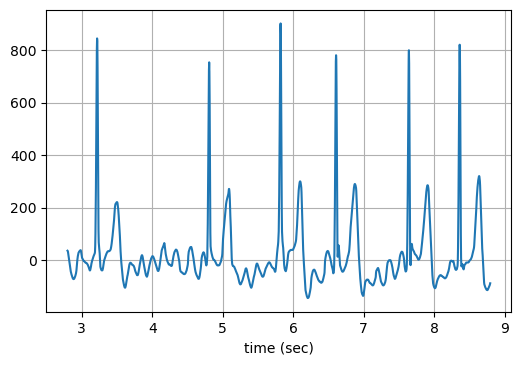

In [5]:
n= 150
sig = sio.loadmat(os.path.join(dpath,Alist.iloc[n,0]+'.mat'))  # sig : Alist에서 (n+1)번째의 이름을 가져옴
sig = sig['val']                                               # sig['val'] : Alist의 데이터가 각각 9000개의 측정값을 가짐

# sig.shape = (1,9000)
# t : 0부터 8999의 수를 300 으로 나눈 수(300Hz로 샘플링)- 시간(sec을 나타냄) 
# ex) t에 대해서 연속된 1800개를 고르면 6초를 나타냄
# r1 : 500과 1000 사이의 랜덤 정수
t = np.arange(0,sig.shape[-1])/300
r1 = random.randint(500,1000)

# dpi 매개변수 : 그래프를 고해상도로 그려줌
# sig[0]의 인덱스와 t의 인덱스가 서로 대응되므로 주파수에 상관없이 대응되는 값을 가져올 수 있음
# t에 대해서 인덱스 (r1~r1+1800)까지를 시간축(x축)에 plot
# Alist에서 가져온 데이터의 측정값에서 인덱스 (r1~r1+1800) 까지를 y축에 plot
plt.figure(dpi=100)
plt.plot(t[r1:r1+1800],sig[0,r1:r1+1800])
plt.xlabel('time (sec)')
plt.grid('on')
plt.show()

## Data Loader 정의
- minibatch size, data path, Nlist, Alist, L을 입력으로 하여 데이터를 가져오는 함수를 정의합니다.
- L개 만큼의 샘플을 랜덤한 구간게에서 추출할 수 있도록 하고, 매 배치마다 N과 A를 같은 수로 가져오도록 합니다.
- N인 sample은 label이 0이 되도록, A인 sample은 label이 1이 되도록 하여 label을 정의합니다.

In [6]:
def data_iter(batch_size, dpath, Nlist, Alist, L):
    # Nlist와 Alist의 인덱스를 리스트로 받음
    # indicesN을 랜덤하게 섞음 - 학습순서 랜덤화
    num_examplesN = len(Nlist)
    num_examplesA = len(Alist)
    indicesN = list(range(num_examplesN))
    indicesA = list(range(num_examplesA))
    # The examples are read at random, in no particular order
    random.shuffle(indicesN)
    
    # Nlist의 인덱스를 batch_size 단위로 받아와서 Tensor type으로 만듬
    # 계속 받아오다가 만약 인덱스가 Nlist 전체 데이터의 크기보다 커지면 마지막 데이터의 인덱스까지만 받아옴
    for i in range(0, num_examplesN, batch_size):
        batch_indicesN = torch.tensor(indicesN[i:min(i+batch_size, num_examplesN)])
        
        # indicesA를 랜덤하게 섞어서 첫 데이터부터 batch_size만큼 가져옴
        # i의 값이 바뀔때마다 랜덤하게 섞어 계속해서 정해진 batch_size만큼 가져올 수 있도록 함
        random.shuffle(indicesA)
        batch_indicesA = torch.tensor(indicesA[0:min(batch_size, num_examplesA)])
        
        # features : (batch_size * L) size의 zero tensor로 초기화
        # labels : batch_size 만큼의 zero tensor로 초기화
        features = torch.zeros((batch_size,L))
        labels = torch.zeros((batch_size,))
        
        # 0부터 int(batch_size/2)까지의 범위에 대해 sign과 singa 정의
        # int(batch_size/2)개의 sign과 siga에서 정의됨
        # batch_size의 절반은 sign, 절반은 siga로 채워줌
        for bi in range(0, int(batch_size/2)):
            sign = sio.loadmat(os.path.join(dpath,Nlist.iloc[bi,0]+'.mat'))  
            siga = sio.loadmat(os.path.join(dpath,Alist.iloc[bi,0]+'.mat'))
            sign = sign['val']
            siga = siga['val']
            
            # 250~750 범위에서 랜덤한 정수 r1과 r2 설정
            r1 = random.randint(250,750)
            r2 = random.randint(250,750)
            #r1 = 500
            #r2 = 500
            
            # r1, r2 - random한 구간에 대해
            # features의 짝수번째 인덱스에는 normal ECG 신호의 sample을 L개 가져옴
            # features의 홀수번째 인덱스에는 Atrial ECG 신호의 sample을 L개 가져옴
            # bi 값에 따라 계속 채워나감
            features[2*bi,:] = torch.tensor(sign[0,r1:r1+L])
            features[2*bi+1,:] = torch.tensor(siga[0,r2:r2+L])
            
            # labels의 짝수 인덱스(Normal)는 0의 값을, 홀수 인덱스(Atrial)는 1의 값을 부여 
            labels[2*bi] = 0
            labels[2*bi+1] = 1
            
        # 0.001*features와 labels 반환
        yield 0.001*features, labels

- 정의한 Data Loader가 제대로 구현이 되었는지 확인해 봅니다.

torch.Size([4, 1800])
torch.Size([4])


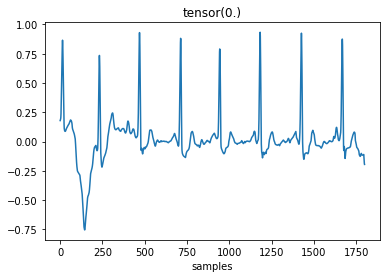

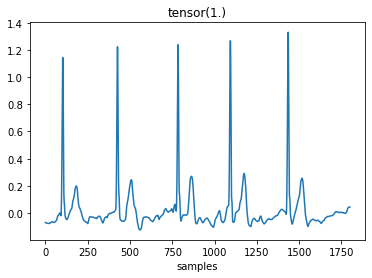

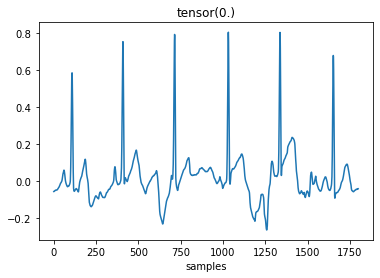

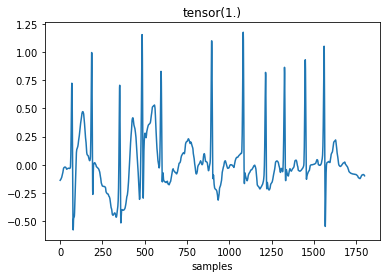

In [7]:
# 지정한 L, batch_size에 대해서 확인
L = 1800
batch_size=4
i = 0
for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
    print(X_tr.shape)
    print(y_tr.shape)
    i=i+1
    for n in range(len(X_tr)):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break

<b>Hyperparameters, Model, Loss function, Optimization Algorithm 정의</b>

In [8]:
L = 2100
batch_size=4
lr = 0.005
num_epochs = 100

- pytorch에서 미리 정의된 것들을 활용하여 편하게 model, loss function, optimization algorithm을 정의할 수 있습니다.

In [9]:
## model 정의
# nn.Linear(input_dimension, output_dimension, bias = True)에 맞춰서 선형모델을 생성
# nn.Sequential() : nn.Linear을 인수로 받아 입력값이 들어오면 결과를 반환
net = nn.Sequential(nn.Linear(L, 2))   

## loss function : CrossEntropyLoss 정의
# label과 prediction 간의 entropy를 계산 : label과 prediction 사이의 유사정도 파악
loss = nn.CrossEntropyLoss(reduction='mean')

## optimization algorithm 정의 : gradient descent 사용
# net.parameters : Linear(in_features=1800, out_features=2, bias=True)
# learning rate를 받아서 최적화 진행
alg = torch.optim.SGD(net.parameters(), lr)

<b>Training a Model</b>
- 준비된 data loader, model, loss function, algorithm을 통해 학습을 진행하여 train set에 대한 loss값과 classification accuracy를 관찰합니다.

In [10]:
for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    
    # X_tr, y_tr : 0.001*features, labels
    # y_tr_pred : X_tr의 예측값
    # l : y_tr_prd와 y_tr의 loss 계산
    # l_train에 l.sum()을 append 해줌
    # .backward()를 호출하여 loss에 대한 gradient를 계산하고 저장함
    # .step()을 호출하여 parameter 갱신
    # .zero_grad() : gradient 0으로 초기화
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        y_tr_pred = net(X_tr)
        l = loss(y_tr_pred, y_tr.type(torch.LongTensor))
        l_train.append(l.sum().detach().numpy())
        l.backward()
        alg.step()
        alg.zero_grad()
        
        ## accuracy
        # .softmax()를 호출하여 y_tr_pred의 probability 특성을 구해줌
        # torch.argmax()
        # dim = 1(row) probability 특성 중의 최대값의 인덱스(0/1)가 y_tr과 같으면 sum
        # 총 같은 개수를 Ncorrect에 업데이트
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.softmax(1),dim=1)).numpy()
        
        # N에 X_tr의 길이(batch_size)를 더해서 업데이트
        # 시행횟수 i 업데이트 
        N += len(X_tr)
        i=i+1
        
    # epoch 10회당 한번씩 평균 loss와 accuracy 출력
    # N = batch_size * i    
    if epoch%10==0:
        print(f'epoch #{epoch},train loss: {np.sum(l_train)/i}')
        print(f'accuracy of train set: {100*Ncorrect/(N)} %')

epoch #0,train loss: 0.548835400390625
accuracy of train set: 73.78 %
epoch #10,train loss: 0.256263720703125
accuracy of train set: 91.88 %
epoch #20,train loss: 0.17655103759765625
accuracy of train set: 97.38 %
epoch #30,train loss: 0.13461307373046874
accuracy of train set: 99.44 %
epoch #40,train loss: 0.111955029296875
accuracy of train set: 99.72 %
epoch #50,train loss: 0.09216868896484375
accuracy of train set: 99.82 %
epoch #60,train loss: 0.0791883544921875
accuracy of train set: 99.76 %
epoch #70,train loss: 0.068188916015625
accuracy of train set: 99.82 %
epoch #80,train loss: 0.06160732421875
accuracy of train set: 99.88 %
epoch #90,train loss: 0.0549951171875
accuracy of train set: 99.9 %


In [17]:
100*Ncorrect/(N)

99.88

- 미리 분리해 놓은 valid set에 대한 classification accuracy도 관찰해 봅시다.
- 아마도 overfitting이 되었음을 확인할 수 있을 것 입니다.

In [18]:
## valid set에 대한 accuracy 확인
# train set에 비해서 낮은 accuracy를 확인할 수 있음 : overfitting
for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
    y_vd_pred = net(X_vd)
    print('accuracy of valid set: ', 100*torch.sum(y_vd==torch.argmax(y_vd_pred.softmax(1),dim=1))/Nvd ,' %')

accuracy of valid set:  tensor(52.)  %


- model의 출력은 softmax가 적용되지 않았음을 확인하여 봅니다.
    - pytorch에서 제공하는 crossentropyloss는 0,1,2,.. 로 되어 있는 label에 대해 알아서 처리를 해주기 때문에 label에 대해 one-hot encoding을 해주지 않아도 괜찮습니다.
- softmax를 적용하여 model의 출력을 probability와 같은 특성을 가지도록 변환해 봅니다.
- 각각의 출력이 의미하는 바를 이해해 봅시다.

In [19]:
n = 14

# valid set의 label인 y_vd의 index=14인 요소
print(y_vd[n])

# valid set의 예측값 y_vd_pred의 index=14인 요소
print(y_vd_pred[n])

# y_vd_pred[14]에 softmax를 취한 값 : probability
print(y_vd_pred.softmax(1)[n])

# y_vd_pred[14]의 probaility 중에서 더 큰 값의 인덱스
print(torch.argmax(y_vd_pred.softmax(1)[n]))

tensor(0.)
tensor([ 2.5900, -2.5252], grad_fn=<SelectBackward0>)
tensor([0.9940, 0.0060], grad_fn=<SelectBackward0>)
tensor(0)


## 결론
1. 최종적으로 사용한 하이퍼파라미터들(L, batch_size, lr, num_epochs)의 값들
    - L = 2100
    - batch_size = 4
    - lr = 0.005
    - num_epochs = 100
  
  
2. train set과 valid set 각각의 accuracy
    - train set : 99.88 %
    - valid set : 52 %
  
  
3. train set과 valid set의 결과 차이가 크게 나타난 경우 그 이유에 대한 본인의 생각
    - train set으로 학습을 할 때는 그 train set에 대해 너무 학습이 잘 되서 loss가 적어 accuracy가 좋게 나왔지만, 실제 그 학습을 검증하는 valid set에 있어서는 오히려 loss가 증가했다고 생각한다. 즉, 모델이 지나치게 train set에 맞춰지다 보니 valid set과 같은 다른 데이터가 들어왔을 때는 오히려 그 accuracy가 많이 떨어진 것 같다. 